In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
#import torch.nn as nn
#import accelerate
from datasets import load_dataset

from sklearn.metrics import accuracy_score, f1_score
from collections import Counter

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments, pipeline

from peft import LoraConfig, get_peft_model, TaskType

import os
os.environ["WANDB_DISABLED"] = "true"

In [2]:
# Check if GPU is available, becouse training on CPU is very slow!!!
print(torch.cuda.is_available()) 
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [3]:
dataset = load_dataset("go_emotions")

emotions = dataset["train"].features["labels"].feature.names
num_labels = len(emotions)
print(len(dataset["train"]))
print(num_labels)
print(emotions)


43410
28
['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [4]:
# Get the distribution of emotions in the dataset
emotion_counter = Counter()

for split, split_data in dataset.items():
    for sample in split_data:
        emotion_counter.update(sample["labels"])

emotions_count = {emotion: emotion_counter.get(i, 0) for i, emotion in enumerate(emotions)}

print(emotions_count)

{'admiration': 5122, 'amusement': 2895, 'anger': 1960, 'annoyance': 3093, 'approval': 3687, 'caring': 1375, 'confusion': 1673, 'curiosity': 2723, 'desire': 801, 'disappointment': 1583, 'disapproval': 2581, 'disgust': 1013, 'embarrassment': 375, 'excitement': 1052, 'fear': 764, 'gratitude': 3372, 'grief': 96, 'joy': 1785, 'love': 2576, 'nervousness': 208, 'optimism': 1976, 'pride': 142, 'realization': 1382, 'relief': 182, 'remorse': 669, 'sadness': 1625, 'surprise': 1330, 'neutral': 17772}


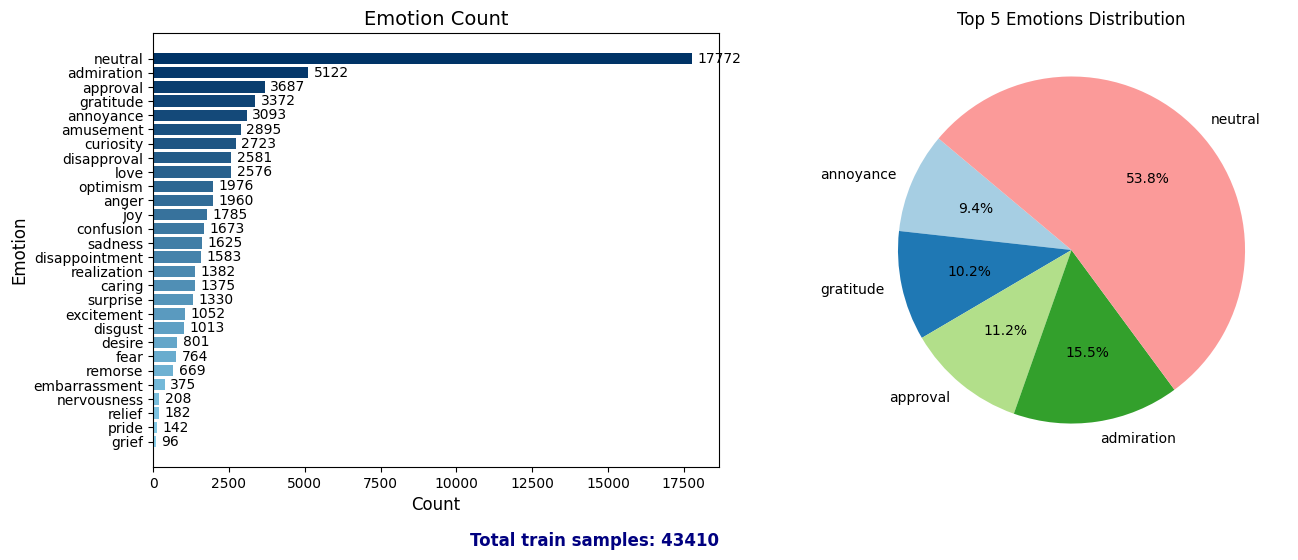

In [5]:
# --- Sort by ascending count ---
sorted_items = sorted(emotions_count.items(), key=lambda x: x[1])
emotions_sorted, counts_sorted = zip(*sorted_items)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Horizontal bar plot (left) ---
import matplotlib.colors as mcolors

# Create a colormap from darkblue to lightblue
cmap = mcolors.LinearSegmentedColormap.from_list("blue_gradient", ["#87CEEB", "#003366"])
# Generate colors from the colormap for each bar
colors = [cmap(i / (len(emotions_sorted) - 1)) for i in range(len(emotions_sorted))]
bars = axes[0].barh(emotions_sorted, counts_sorted, color=colors)
for bar, count in zip(bars, counts_sorted):
    axes[0].text(
        bar.get_width() + max(counts_sorted) * 0.01,
        bar.get_y() + bar.get_height() / 2,
        str(count),
        va='center',
        ha='left',
        fontsize=10,
        fontweight='normal'
    )
axes[0].set_xlabel("Count", fontsize=12)
axes[0].set_ylabel("Emotion", fontsize=12)
axes[0].set_title("Emotion Count", fontsize=14)

# Show total train data at the bottom right
axes[0].text(
    1.0, -0.15, f"Total train samples: {len(dataset['train'])}",
    transform=axes[0].transAxes,
    fontsize=12,
    color="navy",
    ha="right",
    va="top",
    fontweight="bold"
)

# --- Pie chart of top 5 emotions (right) ---
top5_emotions = emotions_sorted[-5:]
top5_counts = counts_sorted[-5:]
axes[1].pie(top5_counts, labels=top5_emotions, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors[:5])
axes[1].set_title("Top 5 Emotions Distribution")

plt.tight_layout(pad=2)
plt.show()


In [6]:
def multi_hot_encode(samples):
    multi_hot = np.zeros(len(emotions))

    for label in samples["labels"]:
        multi_hot[label] = 1

    return {"labels": multi_hot.tolist()}

dataset = dataset.map(multi_hot_encode)

In [7]:
model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Set the format of the dataset to PyTorch tensors
tokenized_dataset.set_format("torch")

In [8]:
convert_to_float = lambda sample: {"float_labels": sample["labels"].to(torch.float)}

tokenized_dataset = (tokenized_dataset
                     .map(convert_to_float, remove_columns=["labels"])
                     .rename_column("float_labels", "labels"))

In [9]:
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(emotions),
    problem_type="multi_label_classification"
)

# LoRA config 
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,     
    r=8,                            
    lora_alpha=16,                  
    lora_dropout=0.05,              
    target_modules=["query", "key", "value"]
)

model = get_peft_model(model, lora_config)

# Show how many params are trainable now
model.print_trainable_parameters()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 463,900 || all params: 109,967,672 || trainable%: 0.4219


In [10]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)
model = model.to(device)

cuda:0


In [11]:
# Define parameters 
LEARNING_RATE = 2e-5
BATCH_SIZE = 16
EPOCHS = 5
WEIGHT_DECAY = 1e-2

In [12]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    fp16=True  
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [13]:
def compute_metrics(pred):
    logits, labels = pred
    preds = (logits > 0.5).astype(int) # Convert probabilities to binary predictions

    f1 = f1_score(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)

    return {
        'f1': f1,
        'accuracy': acc
    }

In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics
)

In [15]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.150200,0.149189,0.000000,0.000000
2,0.147800,0.143006,0.000000,0.000000
3,0.136200,0.134797,0.002504,0.001474
4,0.134000,0.131250,0.118659,0.058422
5,0.132800,0.130259,0.122568,0.061555


TrainOutput(global_step=13570, training_loss=0.14526310402765463, metrics={'train_runtime': 1761.7367, 'train_samples_per_second': 123.202, 'train_steps_per_second': 7.703, 'total_flos': 1.43577260614656e+16, 'train_loss': 0.14526310402765463, 'epoch': 5.0})

In [16]:
multilabel_pipeline = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    top_k=None,  # return all pedictions first
)

Device set to use cuda:0


In [17]:
#result = multilabel_pipeline("I simply can't stand when my computer freezes")
result = multilabel_pipeline("I hate you, but i also like you")
#result = multilabel_pipeline("I’m Not Mad")
result

[[{'label': 'LABEL_0', 'score': 0.1872812658548355},
  {'label': 'LABEL_18', 'score': 0.16913124918937683},
  {'label': 'LABEL_17', 'score': 0.0905744731426239},
  {'label': 'LABEL_25', 'score': 0.07779745012521744},
  {'label': 'LABEL_20', 'score': 0.07737810909748077},
  {'label': 'LABEL_27', 'score': 0.0754484310746193},
  {'label': 'LABEL_1', 'score': 0.06108710914850235},
  {'label': 'LABEL_4', 'score': 0.05910154804587364},
  {'label': 'LABEL_15', 'score': 0.05310790240764618},
  {'label': 'LABEL_5', 'score': 0.03926875442266464},
  {'label': 'LABEL_9', 'score': 0.03810662031173706},
  {'label': 'LABEL_3', 'score': 0.037892427295446396},
  {'label': 'LABEL_24', 'score': 0.03718677535653114},
  {'label': 'LABEL_26', 'score': 0.03527754545211792},
  {'label': 'LABEL_7', 'score': 0.033526163548231125},
  {'label': 'LABEL_13', 'score': 0.03179866820573807},
  {'label': 'LABEL_8', 'score': 0.030444350093603134},
  {'label': 'LABEL_2', 'score': 0.027637720108032227},
  {'label': 'LABEL

In [18]:
def get_emotion(pred):
    """
    Gets the int number after the _ in "LABEL_X"
    e.g.: LABEL_18 yields just the integer 18
    We use this integer as index to get the original emotion name
    """
    pred_emotion_idx = int(pred["label"].split('_')[1])
    return emotions[pred_emotion_idx]

predicted_emotions = [get_emotion(pred) for pred in result[0] if pred["score"] > 0.1]
predicted_emotions

['admiration', 'love']

In [19]:
# === Per-label threshold search (validation) and test evaluation ===
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_recall_fscore_support, accuracy_score

def _sigmoid(x): return 1 / (1 + np.exp(-x))

def _predict_split(trainer, split_ds):
    out = trainer.predict(split_ds)
    y_true = out.label_ids
    y_score = _sigmoid(out.predictions)
    if y_score.ndim == 1: y_score = y_score.reshape(-1, 1)
    return y_true, y_score

# 1) Get validation scores
y_true_val, y_score_val = _predict_split(trainer, tokenized_dataset["validation"])
L = y_true_val.shape[1]
if "label_names" not in globals():
    label_names = [f"L{i}" for i in range(L)]

# 2) Grid-search a separate threshold for each label
grid = np.round(np.arange(0.05, 0.95 + 1e-9, 0.01), 2)
best_thr_per_label = np.zeros(L)
best_f1_per_label  = np.zeros(L)

for j in range(L):
    yj_true  = y_true_val[:, j]
    yj_score = y_score_val[:, j]
    best_f1, best_t = -1, 0.5
    for t in grid:
        yj_pred = (yj_score >= t).astype(int)
        f1 = f1_score(yj_true, yj_pred, zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    best_thr_per_label[j] = best_t
    best_f1_per_label[j]  = best_f1

thr_table = pd.DataFrame({
    "label": label_names,
    "best_thr": best_thr_per_label,
    "val_f1_at_best_thr": best_f1_per_label
}).sort_values("val_f1_at_best_thr", ascending=False).reset_index(drop=True)
display(thr_table.head(15))

# 3) Evaluate on TEST using per-label thresholds
y_true_test, y_score_test = _predict_split(trainer, tokenized_dataset["test"])
y_pred_test = (y_score_test >= best_thr_per_label[None, :]).astype(int)

# Summary metrics
subset_acc = accuracy_score(y_true_test, y_pred_test)
micro_f1   = f1_score(y_true_test, y_pred_test, average="micro", zero_division=0)
macro_f1   = f1_score(y_true_test, y_pred_test, average="macro", zero_division=0)
samples_f1 = f1_score(y_true_test, y_pred_test, average="samples", zero_division=0)

print("=== TEST (per-label thresholds) ===")
print(f"subset_accuracy: {subset_acc:.4f}")
print(f"micro_f1:       {micro_f1:.4f}")
print(f"macro_f1:       {macro_f1:.4f}")
print(f"samples_f1:     {samples_f1:.4f}")

# Per-label breakdown
p, r, f, s = precision_recall_fscore_support(y_true_test, y_pred_test, average=None, zero_division=0)
per_label = pd.DataFrame({
    "label": label_names, "precision": p, "recall": r, "f1": f, "support": s, "thr_used": best_thr_per_label
}).sort_values("support", ascending=False).reset_index(drop=True)
display(per_label.head(20))


,label,best_thr,val_f1_at_best_thr
0,L15,0.64,0.906942
1,L27,0.32,0.641020
2,L18,0.17,0.545106
3,L0,0.13,0.346678
4,L7,0.07,0.214286
5,L24,0.05,0.186992
6,L17,0.09,0.177719
7,L1,0.06,0.175394
8,L10,0.06,0.172492
9,L25,0.06,0.168525


=== TEST (per-label thresholds) ===
subset_accuracy: 0.0601
micro_f1:       0.2869
macro_f1:       0.1512
samples_f1:     0.3019


,label,precision,recall,f1,support,thr_used
0,L27,0.514886,0.822608,0.633348,1787,0.32
1,L0,0.225467,0.765873,0.348375,504,0.13
2,L15,0.946541,0.855114,0.898507,352,0.64
3,L4,0.067545,0.686610,0.122991,351,0.06
4,L3,0.096008,0.631250,0.166667,320,0.06
5,L7,0.181269,0.211268,0.195122,284,0.07
6,L10,0.090849,0.513109,0.154366,267,0.06
7,L1,0.081796,0.386364,0.135010,264,0.06
8,L18,0.511719,0.550420,0.530364,238,0.17
9,L2,0.063776,0.126263,0.084746,198,0.05


In [20]:
# === Surface interesting errors on TEST ===
import pandas as pd
import numpy as np

# Ensure we have y_true_test/y_score_test/y_pred_test from A1 cell; otherwise recompute
if 'y_true_test' not in globals() or 'y_pred_test' not in globals():
    y_true_test, y_score_test = _predict_split(trainer, tokenized_dataset["test"])
    y_pred_test = (y_score_test >= 0.5).astype(int)

texts_test = tokenized_dataset["test"]["text"]

def labels_to_str(row):
    return ", ".join(np.array(label_names)[np.where(row==1)[0]])

df_err = pd.DataFrame({
    "text": texts_test,
    "true": [labels_to_str(y_true_test[i]) for i in range(len(texts_test))],
    "pred": [labels_to_str(y_pred_test[i]) for i in range(len(texts_test))]
})
df_err = df_err[df_err["true"] != df_err["pred"]]

print("Total misclassified samples:", len(df_err))
display(df_err.sample(8, random_state=42))


Total misclassified samples: 5101


,text,true,pred
186,"I didn't know that, thanks for the clarification.",L15,"L0, L15"
2754,"will do, thanks for the heads up!",L15,"L0, L15"
1319,"I don't know who wrote what, but good call - t...","L0, L4",L0
4182,"wow, we really live in future","L0, L13",L0
1717,toxic players will sure show you the ways soon...,L20,L0
3636,The Ethical code of conduct. However it's subj...,L4,"L4, L10, L27"
240,We need another goal to show for it. Come on b...,L27,"L4, L27"
1056,What was I expecting smh,L6,"L1, L3, L4, L7, L10, L27"


In [21]:
# === Best & worst labels by F1 (TEST) ===
from sklearn.metrics import precision_recall_fscore_support

p, r, f, s = precision_recall_fscore_support(y_true_test, y_pred_test, average=None, zero_division=0)
table = pd.DataFrame({"label": label_names, "precision": p, "recall": r, "f1": f, "support": s})
best5  = table.sort_values("f1", ascending=False).head(5)
worst5 = table.sort_values("f1", ascending=True).head(5)
print("Top-5 labels by F1:")
display(best5)
print("Bottom-5 labels by F1:")
display(worst5)


Top-5 labels by F1:


,label,precision,recall,f1,support
15,L15,0.946541,0.855114,0.898507,352
27,L27,0.514886,0.822608,0.633348,1787
18,L18,0.511719,0.550420,0.530364,238
0,L0,0.225467,0.765873,0.348375,504
6,L6,0.196809,0.241830,0.217009,153


Bottom-5 labels by F1:


,label,precision,recall,f1,support
5,L5,0.0,0.0,0.0,135
14,L14,0.0,0.0,0.0,78
11,L11,0.0,0.0,0.0,123
8,L8,0.0,0.0,0.0,83
12,L12,0.0,0.0,0.0,37


<Figure size 640x480 with 0 Axes>

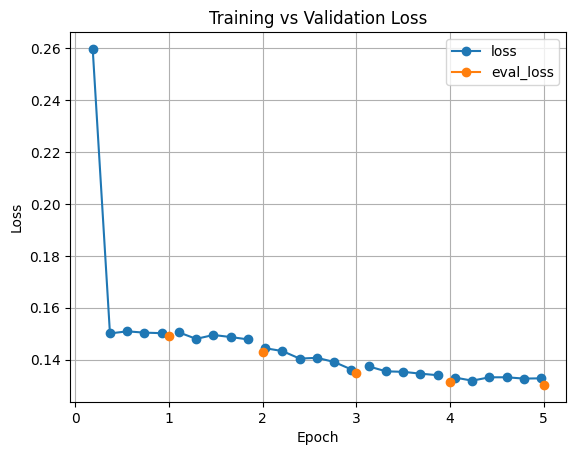

In [22]:
# === Plot learning curves from Trainer logs ===
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(trainer.state.log_history)
# Keep useful keys only
keys = ["epoch", "loss", "eval_loss", "eval_f1", "eval_accuracy"]
curves = logs[[k for k in keys if k in logs.columns]].dropna(how="all")

# Loss curve
plt.figure()
curves.plot(x="epoch", y=[c for c in ["loss","eval_loss"] if c in curves.columns], marker="o")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()




In [23]:
# === Efficiency snapshot ===
import torch, numpy as np, pandas as pd

def count_params(m):
    total = sum(p.numel() for p in m.parameters())
    trainable = sum(p.numel() for p in m.parameters() if p.requires_grad)
    return total, trainable

total_p, trainable_p = count_params(model)
runtime_sec = float(getattr(trainer.state, "train_runtime", np.nan))
steps_per_sec = float(getattr(trainer.state, "train_steps_per_second", np.nan))
samples_per_sec = float(getattr(trainer.state, "train_samples_per_second", np.nan))

try:
    vram_mb = torch.cuda.max_memory_allocated() / (1024**2)
except:
    vram_mb = np.nan

eff = pd.DataFrame([{
    "strategy": "current_model",
    "total_params": total_p,
    "trainable_params": trainable_p,
    "train_runtime_s": runtime_sec,
    "steps_per_s": steps_per_sec,
    "samples_per_s": samples_per_sec,
    "approx_max_VRAM_MB": vram_mb
}])
display(eff)


,strategy,total_params,trainable_params,train_runtime_s,steps_per_s,samples_per_s,approx_max_VRAM_MB
0,current_model,109967672,463900,NaN,NaN,NaN,1314.01709


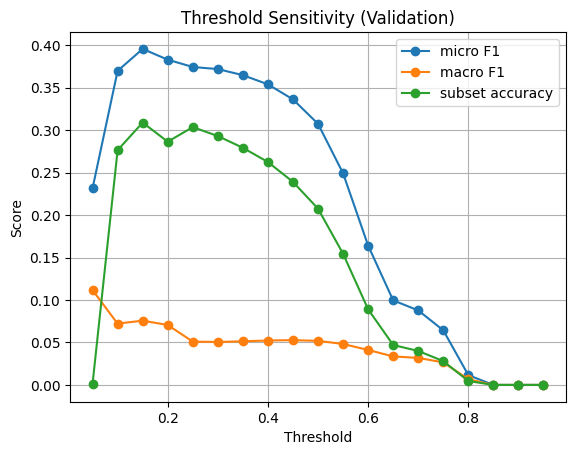

In [24]:
# === Single-threshold sensitivity (VAL) ===
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score

y_true_val, y_score_val = _predict_split(trainer, tokenized_dataset["validation"])
ths = np.linspace(0.05, 0.95, 19)
micro_f1s, macros, accs = [], [], []

for t in ths:
    y_pred = (y_score_val >= t).astype(int)
    micro_f1s.append(f1_score(y_true_val, y_pred, average="micro", zero_division=0))
    macros.append(f1_score(y_true_val, y_pred, average="macro", zero_division=0))
    accs.append(accuracy_score(y_true_val, y_pred))

plt.figure()
plt.plot(ths, micro_f1s, marker="o", label="micro F1")
plt.plot(ths, macros, marker="o", label="macro F1")
plt.plot(ths, accs, marker="o", label="subset accuracy")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Sensitivity (Validation)")
plt.grid(True)
plt.legend()
plt.show()
